# 데이터 준비

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-06-07 07:09:46--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.160.208, 52.217.229.96, 52.216.153.54, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.160.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  21.0MB/s    in 0.6s    

2024-06-07 07:09:47 (21.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
# !mv /content/__MACOSX/._jena_climate_2009_2016.csv '/content/drive/MyDrive/Colab Notebooks/github/aiffel/10_study/data'

In [4]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)

print(len(header))
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
15
420451


In [5]:
# 420451개를 넘파이 배열로 만들기 (첫번째 Date Time열 제외)
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

print(temperature.shape)
print(temperature[0:3]) # T (degC) 열데이터 (섭씨임)
print(raw_data.shape)

(420451,)
[-8.02 -8.41 -8.51]
(420451, 14)


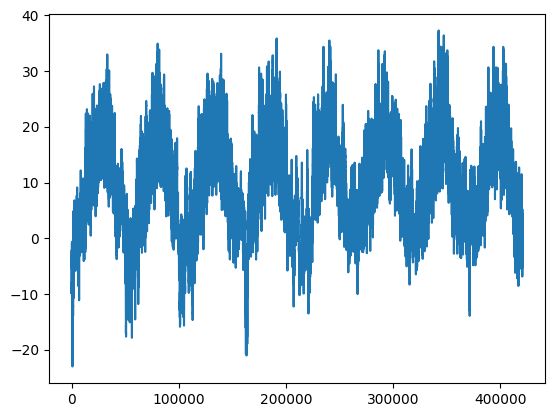

In [6]:
# 기온 그래프
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

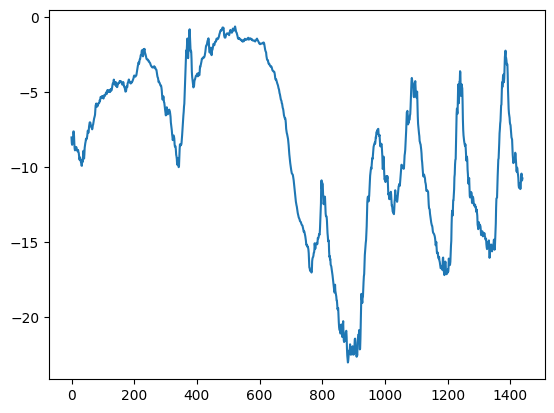

In [7]:
# 처음 10일간 온도 데이터 그래프
plt.plot(range(1440), temperature[:1440])
plt.show()
# 이 10일은 추운 겨울인걸 확인할 수 있다

In [8]:
# 시계열 데이터에선
# 검증 데이터와 테스트 데이터가 훈련 데이터보다 최신이어야함 !!!

# 훈련, 검증, 테스트 데이터 분할 (훈련 50, 검증 25, 테스트 25)
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [9]:
# 데이터를 정규화하기 (평균 0 표준편차 1)
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [10]:
# timeseries_dataset_from_array() : 직접 제너레이터 구현안해도 요걸로 대체해서 데이터를 샘플링할수있음
# 훈련, 검증, 테스트 데이터 분할
from tensorflow import keras

sampling_rate = 6 # 10분마다 데이터가 생성되니 6개면 60분, 즉 1시간당 하나가 샘플링되게끔
sequence_length = 120 # 5일간 데이터길이
delay = sampling_rate * (sequence_length + 24 - 1) # 24시간후
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [11]:
for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


In [13]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        # 데이터를 정규화했었으니 반대로 다시 섭씨 온도를 구하려면
        # 표준편차를 곱하고 평균을 더해야함
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")
# 그냥 계산해본 결과는
# 검증 MAE: 2.44
# 테스트 MAE: 2.62

검증 MAE: 2.44
테스트 MAE: 2.62


# 기본적인 머신러닝 모델로 예측해보기
- Flatten과 Dense

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.h5")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")
# Flatten과 Dense 결과는
# 테스트 MAE: 2.69 (오차가 더커짐)

Epoch 1/10
819/819 [==============================] - 50s 59ms/step - loss: 12.4532 - mae: 2.7270 - val_loss: 10.4685 - val_mae: 2.5475
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


819/819 [==============================] - 45s 55ms/step - loss: 8.9174 - mae: 2.3481 - val_loss: 10.7768 - val_mae: 2.5818
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 8.1655 - mae: 2.2489 - val_loss: 10.3859 - val_mae: 2.5412
Epoch 4/10
819/819 [==============================] - 51s 62ms/step - loss: 7.7172 - mae: 2.1853 - val_loss: 11.2187 - val_mae: 2.6487
Epoch 5/10
819/819 [==============================] - 47s 58ms/step - loss: 7.4014 - mae: 2.1408 - val_loss: 11.2890 - val_mae: 2.6545
Epoch 6/10
819/819 [==============================] - 38s 46ms/step - loss: 7.1711 - mae: 2.1068 - val_loss: 10.6259 - val_mae: 2.5687
Epoch 7/10
819/819 [==============================] - 38s 46ms/step - loss: 6.9647 - mae: 2.0780 - val_loss: 11.7642 - val_mae: 2.7179
Epoch 8/10
819/819 [==============================] - 48s 58ms/step - loss: 6.8231 - mae: 2.0564 - val_loss: 10.9895 - val_mae: 2.6132
Epoch 9/10
819/819 [==============================] - 46s 55ms/ste

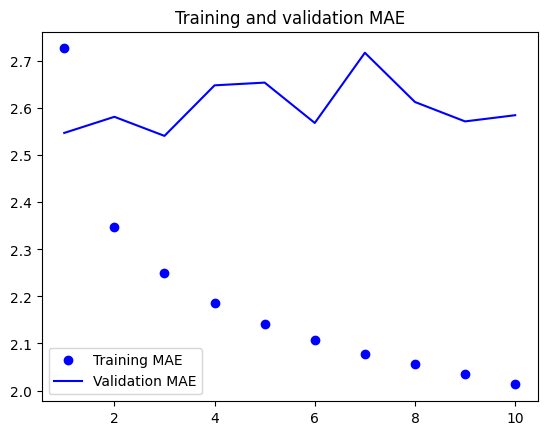

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# 1D 합성곱 모델로 예측해보기
- Conv1D 이용

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.h5")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")
# 1D 합성곱 결과는
# Flatten과 Dense보다 결과보다 나쁨
# 3.03이나 나옴

Epoch 1/10
819/819 [==============================] - 49s 56ms/step - loss: 22.3129 - mae: 3.7104 - val_loss: 15.4264 - val_mae: 3.1057
Epoch 2/10
819/819 [==============================] - 41s 50ms/step - loss: 15.8468 - mae: 3.1704 - val_loss: 14.7510 - val_mae: 3.0294
Epoch 3/10
819/819 [==============================] - 48s 58ms/step - loss: 14.6047 - mae: 3.0415 - val_loss: 15.9241 - val_mae: 3.1412
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 13.8062 - mae: 2.9548 - val_loss: 16.9651 - val_mae: 3.2360
Epoch 5/10
819/819 [==============================] - 52s 63ms/step - loss: 13.0771 - mae: 2.8771 - val_loss: 15.9625 - val_mae: 3.1555
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 12.4996 - mae: 2.8084 - val_loss: 13.9799 - val_mae: 2.9469
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 11.9808 - mae: 2.7504 - val_loss: 15.2040 - val_mae: 3.0587
Epoch 8/10
819/819 [============================

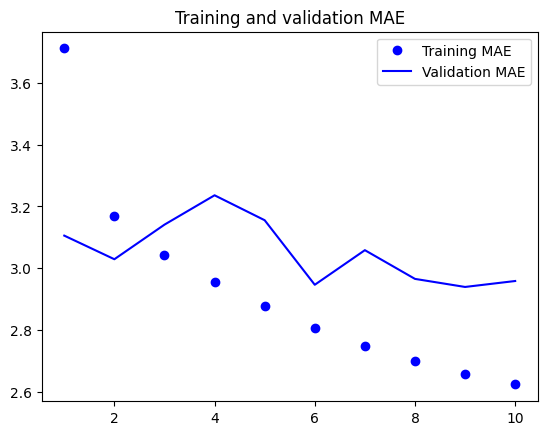

In [18]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


# 순환 신경망 중 LSTM으로 해보기
- Flatten은 데이터를 펼쳤기에 입력데이터에 대한 시간개념을 잃어버렸고, 합성곱 모델도 비슷한 방식으로 처리했으며 폴링을 적용해서 순서 정보를 잃어벼렸다.
- 때문에 Long Short-Term Memory(LSTM)으로 해보자

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.h5")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")
# 지금까지 가장낮은
# 2.58을 기록

Epoch 1/10
819/819 [==============================] - 46s 54ms/step - loss: 48.5733 - mae: 5.1069 - val_loss: 14.2871 - val_mae: 2.8547
Epoch 2/10
819/819 [==============================] - 40s 49ms/step - loss: 11.8060 - mae: 2.6550 - val_loss: 9.9206 - val_mae: 2.4578
Epoch 3/10
819/819 [==============================] - 41s 50ms/step - loss: 10.0131 - mae: 2.4615 - val_loss: 9.4507 - val_mae: 2.3989
Epoch 4/10
819/819 [==============================] - 42s 51ms/step - loss: 9.4271 - mae: 2.3922 - val_loss: 9.5356 - val_mae: 2.4102
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 9.0161 - mae: 2.3398 - val_loss: 9.7339 - val_mae: 2.4332
Epoch 6/10
819/819 [==============================] - 49s 59ms/step - loss: 8.6834 - mae: 2.2960 - val_loss: 10.0054 - val_mae: 2.4658
Epoch 7/10
819/819 [==============================] - 41s 49ms/step - loss: 8.3981 - mae: 2.2581 - val_loss: 10.0269 - val_mae: 2.4677
Epoch 8/10
819/819 [==============================] - 50

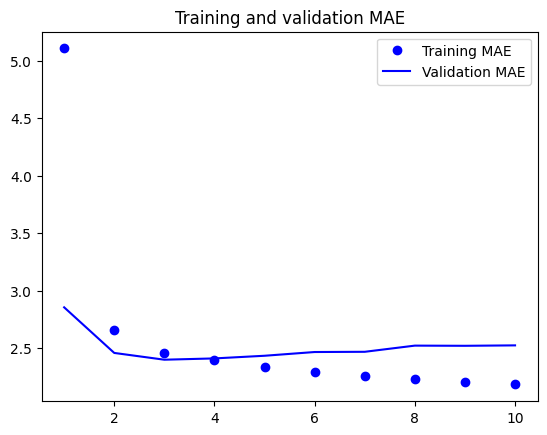

In [20]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# 순환 신경망 이해하기 !!!

## numpy로 구현한 RNN

In [26]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))

# 랜덤한 가중치 만들기
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_sequence = np.stack(successive_outputs, axis=0)
print(final_output_sequence.shape)
print(final_output_sequence)

(100, 64)
[[0.99999977 0.99999995 0.99999672 ... 0.99999774 0.99999899 0.99999998]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


## 케라스의 Simple RNN

## 어떤 길이의 시퀀스도 처리할수 있는 RNN

In [32]:
num_features = 14
inputs = keras.Input(shape=(None, num_features)) # timesteps가 없는것(None)이라 어떤 길이라도 처리가능
outputs = layers.SimpleRNN(16)(inputs)

## 마지막 출력 스텝만 출력하는 RNN

In [31]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
# return_sequences=False가 기본값임
# 마지막 스텝만 출력하겠다는 뜻
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


## 전체 시퀀스를 반환하는 RNN

In [33]:
num_features = 14
steps = 120
# return_sequences=True는 모든 시퀀스를 반환하겠다라는 뜻
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


## 스태킹 RNN (여러 개의 순환층을 두는것)
- 이경우에는 중간층들이 전체 시퀀스를 반환하도록 해야함

In [34]:
inputs = keras.Input(shape=(steps, num_features))
# return_sequences=True는 모든 시퀀스를 반환하겠다라는 뜻
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)